# Atividade 2 - Parte A - Transferência de Estilo Neural

Grupo:<br>
Aderson Lucas Guimarães Mendonça Medeiros<br>
Andrei Ben-Hur do Rego Paz<br> 
Tiago Rocha de Almeida 

### Notebook baseado no artigo: [markojerkic style transfer article](https://markojerkic.com/style-transfer-keras/)

### 1) Questão única: Faça a transferência de estilio de uma imagem de uma pintura a sua escolha para uma imagem de conteúdo também de sua escolha, mas usando as features da rede pré-treinada Resnet 50, que, por sua vez, já está importada pelo keras na célula abaixo:

#### a) Explique o que acontece com a imagem gerada conforme as iterações avançam.

#### b) Faça pelo menos três combinações de pesos de conteúdo, estilo e variância total, de modo que dois deles sejam maiores que o terceiro e compare os resultados das imagens geradas para um mesmo número de iterações.

 ## 1 - Importando dependências e algumas constantes

### * Imports:

In [227]:
# importar os pacotes necessários
import time
import numpy as np
import tensorflow.contrib.keras.api.keras.backend as K
import cv2 
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.contrib.keras.api.keras.applications import vgg19, vgg16, resnet50 # Resnet 50 importada aqui
from tensorflow.contrib.keras.api.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from ipywidgets import Video, Image

### * Constantes:

In [237]:
# carregar a image e a pintura escolhida, além de um diretório para os arquivos gerados
CONTENT_IMG_PATH = 'images/image_at2a.jpg'
STYLE_IMG_PATH = 'images/style.jpg'
OUTPUT_PATH = 'images/output/gen_image_new_style.jpg'
VIDEO_WIDTH = 800
VIDEO_HEIGHT = 500

# quantidade de iterações ao processar a imagem
ITER = 10

# Pesos das funções perda (losses)
CONTENT_WEIGHT = 0.1
STYLE_WEIGHT = 0.5
TV_WEIGHT = 1.0

In [238]:
# Definindo o formato da imagem de saída
height, weight = load_img(CONTENT_IMG_PATH).size
img_h = 200
img_w = int(height * img_h / weight)

## 2 - Pré-processamento da imagem

#### Aqui estamos lendo a imagem a partir de seu arquivo (imagem do tipo Pillow) e convertendo para numpy array: 

In [239]:
# carrega a imagem, transforma em array, redimensiona e a define como float
def preprocess(img_path):
    img = load_img(img_path)
    img = img_to_array(img)
    img = cv2.resize(img, (img_w, img_h))
    img = img.astype('float64')
    
    # Adiciona um novo eixo (representando o batch)
    img = np.expand_dims(img, axis=0)
    img = resnet50.preprocess_input(img) # Tem que modificar para a resnet 50
    return img

In [240]:
# desfaz as transformações relazidas na função preprocess
def deprocess_image(img):
    if K.image_data_format() == 'channels_first':
        img = img.reshape((3, img_h, img_w))
        img = img.transpose((1, 2, 0))
    else:
        img = img.reshape((img_h, img_w, 3))
        
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    
    # converte de 'BGR'-->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

#### Aqui vamos inicializar as variáveis com a imagem de conteúdo, de estilo e a imagem gerada também:

In [241]:
# Create Keras variables of input images
content_img = K.variable(preprocess(CONTENT_IMG_PATH))
style_img = K.variable(preprocess(STYLE_IMG_PATH))

if K.image_data_format() == 'channels_first':
    gen_img = K.placeholder(shape=(1, 3, img_h, img_w))
else:
    gen_img = K.placeholder(shape=(1, img_h, img_w, 3))

# Create a single tensor containing all three images
input_tensor = K.concatenate([content_img, style_img, gen_img], axis=0)

# Create a resnet50 model by running the input tensor though the resnet50 convolutional
# neural network, excluding the fully connected layers
model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
print('Model loaded')

Model loaded


#### Aqui cria-se um dicionário com as saídas das camadas, em que cada chave será o nome de uma camada e o valor da chave, os valores de saída da respectiva camada:

In [242]:
# Create an output dictionary
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [243]:
outputs_dict

{'input_6': <tf.Tensor 'concat_5:0' shape=(3, 200, 320, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1_5/Relu:0' shape=(3, 200, 320, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_5/Relu:0' shape=(3, 200, 320, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_5/MaxPool:0' shape=(3, 100, 160, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_5/Relu:0' shape=(3, 100, 160, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_5/Relu:0' shape=(3, 100, 160, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_5/MaxPool:0' shape=(3, 50, 80, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_5/Relu:0' shape=(3, 50, 80, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_5/Relu:0' shape=(3, 50, 80, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_5/Relu:0' shape=(3, 50, 80, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_5/MaxPool:0' shape=(3, 25, 40, 256) dtype=float32>,
 'blo

## 3 - Cria-se as funções de perda ou *loss*

In [244]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # Dot product of the flattened feature map and the transpose of the
    # flattened feature map
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, gen):
    assert K.ndim(style) == 3
    assert K.ndim(gen) == 3
    S = gram_matrix(style)
    G = gram_matrix(gen)
    channels = 3
    size = img_h * img_w
    # Euclidean distance of the gram matrices multiplied by the constant
    return K.sum(K.square(S - G)) / (4. * (channels ** 2) * (size ** 2))


def content_loss(content, gen):
    assert K.ndim(content) == 3
    assert K.ndim(gen) == 3
    # Euclidean distance
    return K.sum(K.square(gen - content))


def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_h - 1, :img_w - 1] - x[:, :, 1:, :img_w - 1])
        b = K.square(x[:, :, :img_h - 1, :img_w - 1] - x[:, :, :img_h - 1, 1:])
    else:
        # Move the image pixel by pixel, and calculate the variance
        a = K.square(x[:, :img_h - 1, :img_w - 1, :] - x[:, 1:, :img_w - 1, :])
        b = K.square(x[:, :img_h - 1, :img_w - 1, :] - x[:, :img_h - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## 4 - Inicializa-se a função *loss* total

In [245]:
loss = 0.
# Para a loss de conteúdo, está sendo usad a segunda camada convolucional do quinto bloco convolucional da VGG19
layer_features = outputs_dict['block5_conv2']

content_img_features = layer_features[0, :, :, :]
gen_img_features = layer_features[2, :, :, :]

loss += CONTENT_WEIGHT * content_loss(content_img_features, gen_img_features)

# Camadas usadas para informação de estilo
feature_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

for name in feature_layer_names:
    layer_features = outputs_dict[name]
    
    style_features = layer_features[1, :, :, :]
    gen_img_features = layer_features[2, :, :, :]
    
    s1 = style_loss(style_features, gen_img_features)
    
    # Precisamos dividir a loss pelo número de camadas usadas para o estilo
    loss += (STYLE_WEIGHT / len(feature_layer_names)) * s1

# Adicionamos a loss de variância total sobre a imagem gerada
loss += TV_WEIGHT * total_variation_loss(gen_img)

## 5 - Calcula Loss sobre as imagens usadas e cria uma Classe Evaluator para monitorar a loss e o gradiente na otimização

In [246]:
grads = K.gradients(loss, gen_img)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_output = K.function([gen_img], outputs)

def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_h, img_w))
    else:
        x = x.reshape((1, img_h, img_w, 3))
    # Atualiza a loss e o gradiente
    outs = f_output([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_value = grad_value
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_values

## 6 - Tempo de otimização

Step 0
    loss: 630260544.0
     Image saved. Time: 56.05317664146423
Step 1
    loss: 618023168.0
     Image saved. Time: 54.81991672515869
Step 2
    loss: 618454208.0
     Image saved. Time: 55.55713868141174
Step 3
    loss: 614761856.0
     Image saved. Time: 55.21603727340698
Step 4
    loss: 615604544.0
     Image saved. Time: 55.55062007904053
Step 5
    loss: 613010944.0
     Image saved. Time: 55.51879692077637
Step 6
    loss: 614613760.0
     Image saved. Time: 55.380868911743164
Step 7
    loss: 613151680.0
     Image saved. Time: 56.00112462043762
Step 8
    loss: 615693248.0
     Image saved. Time: 55.15348243713379
Step 9
    loss: 613662080.0
     Image saved. Time: 55.87817907333374


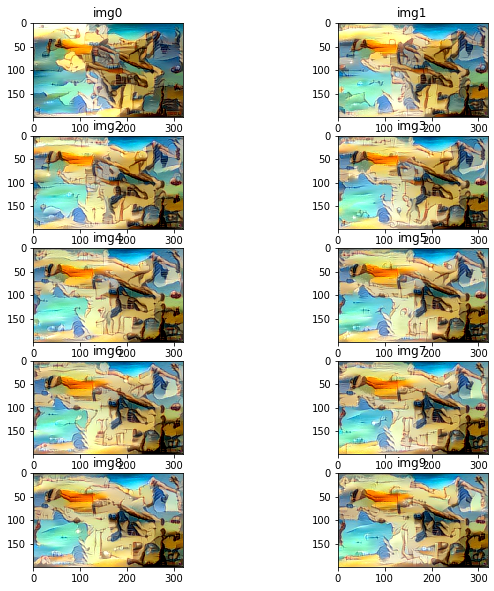

In [247]:
evaluator = Evaluator()

# Run L-BFGS optimizer
x = preprocess(CONTENT_IMG_PATH)
fig, axes = plt.subplots(5, 2, figsize=[10,10])

for ax, i in zip(axes.flatten(), range(ITER)):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=300)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess_image(x)
    cv2.imwrite('images/output/img_new{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))
#     plt.figure(figsize=(20,10))
    ax.setaxis=('off')
    ax.set_title('img{}'.format(i))
    ax.imshow(img)

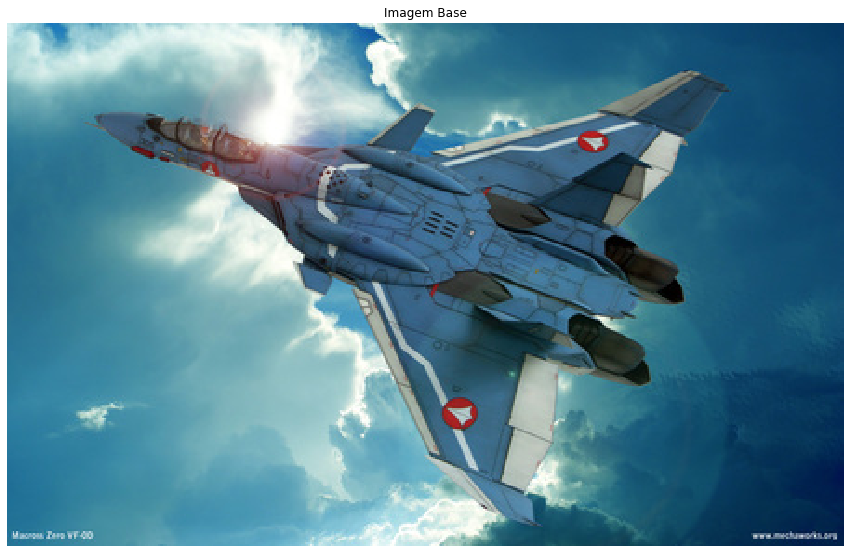

In [151]:
# Plota imagem base
image_base = cv2.imread('images/image_at2a.jpg')
image_base = cv2.cvtColor(image_base, cv2.COLOR_RGB2BGR)
plt.figure(figsize=[15,15])
plt.axis('off')
plt.title('Imagem Base')
plt.imshow(image_base)

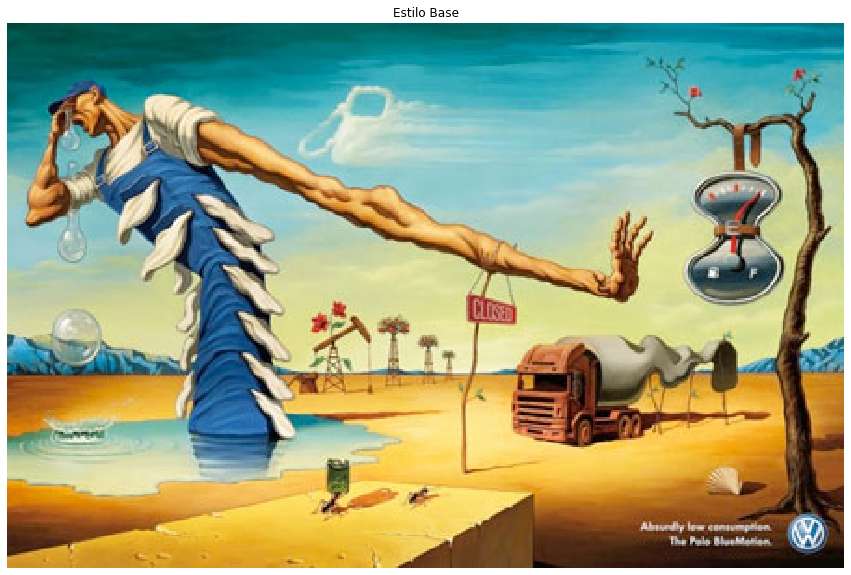

In [154]:
# Plota o estilo base
estilo_base = cv2.imread('images/style.jpg')
estilo_base = cv2.cvtColor(estilo_base, cv2.COLOR_RGB2BGR)
plt.figure(figsize=[15,15])
plt.axis('off')
plt.title('Estilo Base')
plt.imshow(estilo_base)

### Pesos das funções perda (losses)<br>
CONTENT_WEIGHT = 0.1<br>
STYLE_WEIGHT = 0.5<br>
TV_WEIGHT = 1.0<br><br>

<table width='400'>
    <thead>
        <tr>
            <td style="vertical-align:middle;text-align:center">Iteração</td>
            <td style="vertical-align:middle;text-align:center">Loss</td>
            <td style="vertical-align:middle;text-align:center">Tempo de execução<br>(segundos)</td>
    </thead>
    <tr>
        <td style="vertical-align:middle;text-align:center">1</td>
        <td style="vertical-align:middle;text-align:center">630.260.544<p></p></td>
        <td style="vertical-align:middle;text-align:center">56,41</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">2</td>
        <td style="vertical-align:middle;text-align:center">618.023.168</td>
        <td style="vertical-align:middle;text-align:center">55,08</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">3</td>
        <td style="vertical-align:middle;text-align:center">618.454.208</td>
        <td style="vertical-align:middle;text-align:center">55,84</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">4</td>
        <td style="vertical-align:middle;text-align:center">614.761.856</td>
        <td style="vertical-align:middle;text-align:center">55,46</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">5</td>
        <td style="vertical-align:middle;text-align:center">615.604.544</td>
        <td style="vertical-align:middle;text-align:center">55,85</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">6</td>
        <td style="vertical-align:middle;text-align:center">613.010.944</td>
        <td style="vertical-align:middle;text-align:center">55,80</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">7</td>
        <td style="vertical-align:middle;text-align:center">614.613.760</td>
        <td style="vertical-align:middle;text-align:center">55,60</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">8</td>
        <td style="vertical-align:middle;text-align:center">613.151.680</td>
        <td style="vertical-align:middle;text-align:center">56,22</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">9</td>
        <td style="vertical-align:middle;text-align:center">615.693.248</td>
        <td style="vertical-align:middle;text-align:center">55,27</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">10</td>
        <td style="vertical-align:middle;text-align:center">613.662.080</td>
        <td style="vertical-align:middle;text-align:center">55,82</td>
    </tr>
</table>
<br>

<img src='output/first.gif' width='80%'>

<b>a) Explique o que acontece com a imagem gerada conforme as iterações avançam.<br><br>
Resposta:</b><br><br>

Foi observado que ao longo do número de iterações a imagem e o estilo se misturam com maior intensidade. Dependendo do peso relacionado a cada tipo de erro essa mistura muda de intensidade e prevalência em relação a dinâmica da imagem e estilo utilizado.

### Pesos das funções perda (losses)<br>
CONTENT_WEIGHT = 1.0<br>
STYLE_WEIGHT = 2.0<br>
TV_WEIGHT = 3.0<br><br>

<table width="400">
    <thead>
        <tr>
            <td style="vertical-align:middle;text-align:center">Iteração</td>
            <td style="vertical-align:middle;text-align:center">Loss</td>
            <td style="vertical-align:middle;text-align:center">Tempo de execução<br>(segundos)</td>
    </thead>
    <tr>
        <td style="vertical-align:middle;text-align:center">1</td>
        <td style="vertical-align:middle;text-align:center">2066013312<p></p></td>
        <td style="vertical-align:middle;text-align:center">57.67</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">2</td>
        <td style="vertical-align:middle;text-align:center">2006798720</td>
        <td style="vertical-align:middle;text-align:center">58.64</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">3</td>
        <td style="vertical-align:middle;text-align:center">2002005248</td>
        <td style="vertical-align:middle;text-align:center">57.63</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">4</td>
        <td style="vertical-align:middle;text-align:center">2000945664</td>
        <td style="vertical-align:middle;text-align:center">57.11</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">5</td>
        <td style="vertical-align:middle;text-align:center">1997148160</td>
        <td style="vertical-align:middle;text-align:center">56.56</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">6</td>
        <td style="vertical-align:middle;text-align:center">1997030656</td>
        <td style="vertical-align:middle;text-align:center">56.89</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">7</td>
        <td style="vertical-align:middle;text-align:center">1996917248</td>
        <td style="vertical-align:middle;text-align:center">56.16</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">8</td>
        <td style="vertical-align:middle;text-align:center">2001822848</td>
        <td style="vertical-align:middle;text-align:center">56.64</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">9</td>
        <td style="vertical-align:middle;text-align:center">1999671168</td>
        <td style="vertical-align:middle;text-align:center">55.56</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">10</td>
        <td style="vertical-align:middle;text-align:center">1995238528</td>
        <td style="vertical-align:middle;text-align:center">57.74</td>
    </tr>
</table>
<br>

<img src='output/second.gif' width='80%'>

### Pesos das funções perda (losses)<br>
CONTENT_WEIGHT = 1.0<br>
STYLE_WEIGHT = 1.0<br>
TV_WEIGHT = 0.01<br><br>

<table width='400'>
    <thead>
        <tr>
            <td style="vertical-align:middle;text-align:center">Iteração</td>
            <td style="vertical-align:middle;text-align:center">Loss</td>
            <td style="vertical-align:middle;text-align:center">Tempo de execução<br>(segundos)</td>
    </thead>
    <tr>
        <td style="vertical-align:middle;text-align:center">1</td>
        <td style="vertical-align:middle;text-align:center">98.458.176<p></p></td>
        <td style="vertical-align:middle;text-align:center">58,71</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">2</td>
        <td style="vertical-align:middle;text-align:center">85.934.552</td>
        <td style="vertical-align:middle;text-align:center">56,52</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">3</td>
        <td style="vertical-align:middle;text-align:center">81.756.008</td>
        <td style="vertical-align:middle;text-align:center">56,67</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">4</td>
        <td style="vertical-align:middle;text-align:center">80.861.072</td>
        <td style="vertical-align:middle;text-align:center">57,74</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">5</td>
        <td style="vertical-align:middle;text-align:center">79.594.848</td>
        <td style="vertical-align:middle;text-align:center">56,86</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">6</td>
        <td style="vertical-align:middle;text-align:center">78.927.272</td>
        <td style="vertical-align:middle;text-align:center">57,73</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">7</td>
        <td style="vertical-align:middle;text-align:center">79.576.960</td>
        <td style="vertical-align:middle;text-align:center">57,35</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">8</td>
        <td style="vertical-align:middle;text-align:center">78.989.512</td>
        <td style="vertical-align:middle;text-align:center">56,68</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">9</td>
        <td style="vertical-align:middle;text-align:center">78.624.432</td>
        <td style="vertical-align:middle;text-align:center">57,70</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">10</td>
        <td style="vertical-align:middle;text-align:center">78.581.152</td>
        <td style="vertical-align:middle;text-align:center">57,84</td>
    </tr>
</table>
<br>

<img src='output/third.gif' width='80%'/>

### Pesos das funções perda (losses)<br>
CONTENT_WEIGHT = 5.0<br>
STYLE_WEIGHT = 10<br>
TV_WEIGHT = 2.0<br><br>

<table width='400'>
    <thead>
        <tr>
            <td style="vertical-align:middle;text-align:center">Iteração</td>
            <td style="vertical-align:middle;text-align:center">Loss</td>
            <td style="vertical-align:middle;text-align:center">Tempo de execução<br>(segundos)</td>
    </thead>
    <tr>
        <td style="vertical-align:middle;text-align:center">1</td>
        <td style="vertical-align:middle;text-align:center">2.412.444.672</td>
        <td style="vertical-align:middle;text-align:center">114,96</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">2</td>
        <td style="vertical-align:middle;text-align:center">2.274.268.160</td>
        <td style="vertical-align:middle;text-align:center">97,14</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">3</td>
        <td style="vertical-align:middle;text-align:center">2.242.343.936</td>
        <td style="vertical-align:middle;text-align:center">97,96</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">4</td>
        <td style="vertical-align:middle;text-align:center">2.224.990.720</td>
        <td style="vertical-align:middle;text-align:center">91,51</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">5</td>
        <td style="vertical-align:middle;text-align:center">2.214.700.032</td>
        <td style="vertical-align:middle;text-align:center">94,45</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">6</td>
        <td style="vertical-align:middle;text-align:center">2.217.942.272</td>
        <td style="vertical-align:middle;text-align:center">91,76</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">7</td>
        <td style="vertical-align:middle;text-align:center">2.229.166.592</td>
        <td style="vertical-align:middle;text-align:center">93,54</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">8</td>
        <td style="vertical-align:middle;text-align:center">2.207.049.472</td>
        <td style="vertical-align:middle;text-align:center">91,96</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">9</td>
        <td style="vertical-align:middle;text-align:center">2.221.761.024</td>
        <td style="vertical-align:middle;text-align:center">91,63</td>
    </tr>
    <tr>
        <td style="vertical-align:middle;text-align:center">10</td>
        <td style="vertical-align:middle;text-align:center">2.222.576.128</td>
        <td style="vertical-align:middle;text-align:center">90,64</td>
    </tr>
</table>
<br>

<img src='output/fourth.gif' width='80%'>

<b>b) Faça pelo menos três combinações de pesos de conteúdo, estilo e variância total, de modo que dois deles sejam maiores que o terceiro e compare os resultados das imagens geradas para um mesmo número de iterações.<br><br>
Resposta:</b><br>

Foram utilizados três distribuições de erro:

1) CONTENT_WEIGHT = 1.0, STYLE_WEIGHT = 2.0 e TV_WEIGHT = 3.0.<br>
2) CONTENT_WEIGHT = 1.0, STYLE_WEIGHT = 1.0 e TV_WEIGHT = 0.01;<br>
3) CONTENT_WEIGHT = 5.0, STYLE_WEIGHT = 10 e TV_WEIGHT = 2.0; <br>

No primeiro caso, a menor contribuição foi da variância total, seguido pelo peso do conteúdo e estilo com maior valor. Foi observado que o estilo, ao final, predominou em relação ao objeto, um avião de caça. Um caso parecido foi observado no 3, mas o estilo não conseguiu descaracterizar a imagem original apesar do peso para o estilo ser maior, porém com um peso menor para a variância total. É possível que esse fator contribua para aprofundar a predominância de quem tiver o maior peso. Por fim, no caso 2 foi utilizado um peso igual para estilo e imagem e um peso para o total da variância bem menor. O resultado foi parecida com a saída 3, no entanto com menor deformação da imagem base.

In [248]:
# import os

# import imageio
# index_str = ['first', 'second', 'third', 'fourth']
# for idx in index_str:
#     path = 'output/'+idx+'/'
#     filenames = os.listdir(path)
#     images = []
#     for index, filename in enumerate(filenames):
#         if filename.find('jpg') != -1:
#             images.append(imageio.imread(path + filename))
#             output_file = 'output/'+idx+'.gif'
#     imageio.mimsave(output_file, images)